# Algorithmic Trading

In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
import mplfinance as mpf
warnings.filterwarnings('ignore')

In [2]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()
#symbols_list Checa se estão corretos

In [3]:
end_date = '2024-4-26'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*5)
df = yf.download(tickers = symbols_list,
                start = start_date,
                end = end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  502 of 502 completed


Price               adj close       close        high         low        open  \
date       ticker                                                               
2019-04-29 A        74.643982   77.330002   78.440002   77.320000   77.470001   
           AAL      33.323235   33.770000   33.990002   33.310001   33.509998   
           AAPL     49.244453   51.152500   51.492500   50.965000   51.099998   
           ABBV     63.994625   80.300003   80.980003   79.910004   80.459999   
           ABT      71.896584   78.269997   78.629997   77.580002   78.559998   
...                       ...         ...         ...         ...         ...   
2024-04-25 XYL     130.610001  130.610001  131.199997  128.100006  129.619995   
           YUM     141.559998  141.559998  142.169998  140.389999  141.979996   
           ZBH     119.750000  119.750000  121.349998  118.769997  120.709999   
           ZBRA    292.529999  292.529999  293.290009  271.630005  274.359985   
           ZTS     153.360001  153.360001  153.589996  150.039993  150.970001   

Price                  volume  
date       ticker              
2019-04-29 A        2177700.0  
           AAL      5558200.0  
           AAPL    88818800.0  
           ABBV     6444500.0  
           ABT      4355000.0  
...                       ...  
2024-04-25 XYL       963600.0  
           YUM      1693100.0  
           ZBH      1078800.0  
           ZBRA      674700.0  
           ZTS      4567200.0  

[624416 rows x 6 columns]

# 2.Calculate features and technical indicators for each stock.


- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume


$$
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
$$


## Candle Graph of APPL

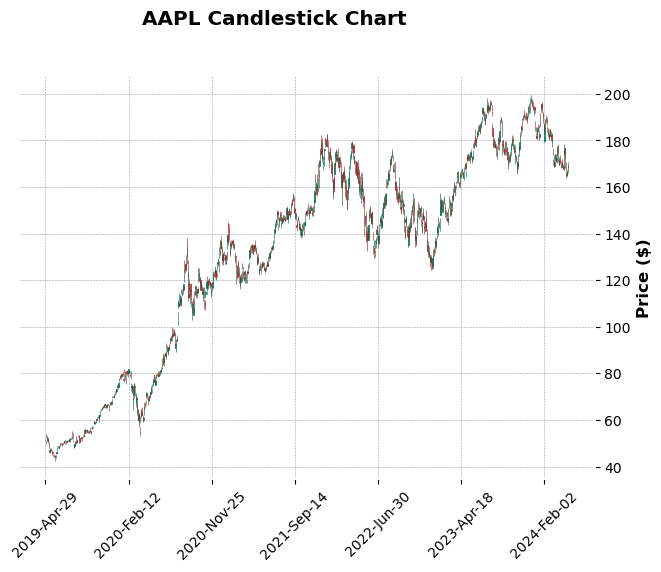

In [11]:
df.reset_index(inplace=True)
df_aapl = df[df['ticker'] == 'AAPL']

df_aapl['date'] = pd.to_datetime(df_aapl['date'])
df_aapl.set_index('date', inplace=True)


mpf.plot(df_aapl[['open', 'high', 'low', 'close', 'volume']], type='candle', style='charles', title='AAPL Candlestick Chart', ylabel='Price ($)')


## Garman Klass Volatility

In [12]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

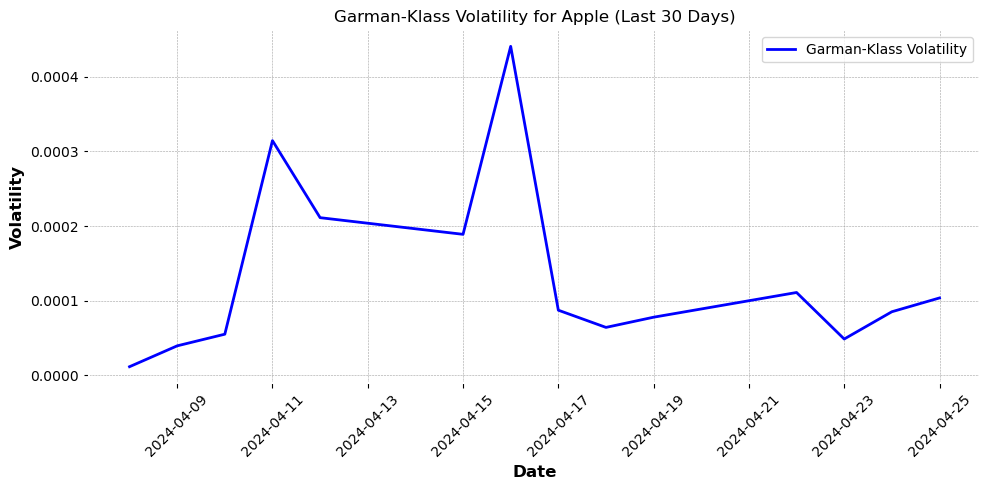

In [14]:
# Sample data frame and setting the date and ticker as index
df.set_index(['date', 'ticker'], inplace=True)

# Convert end_date to datetime, if not already (replace 'end_date' with actual end date as string or pd.Timestamp)
end_date = pd.to_datetime('2024-05-06')  # Example end date
aapl_start_date = end_date - pd.DateOffset(days=30)

# Correct slicing method using .loc and pd.IndexSlice for a range within a MultiIndex
apple_data = df.loc[pd.IndexSlice[aapl_start_date:end_date, 'AAPL'], :]

# Reset index for plotting
apple_data.reset_index(inplace=True)
apple_data['date'] = pd.to_datetime(apple_data['date'])

# Plotting (assuming 'garman_klass_vol' is a valid column in your DataFrame)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(apple_data['date'], apple_data['garman_klass_vol'], label='Garman-Klass Volatility', color='blue')
plt.title('Garman-Klass Volatility for Apple (Last 30 Days)')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Relative Strengh Index (RSI)

$$
RSI_{\text{step one}} = 100 - \left[ \frac{100}{1 + \frac{\text{Average gain}}{\text{Average loss}}} \right]
$$


In [29]:
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=14))
# df.xs('ABBV',level=1)['rsi'].plot() 
aapl_data = df.xs('AAPL', level='ticker')


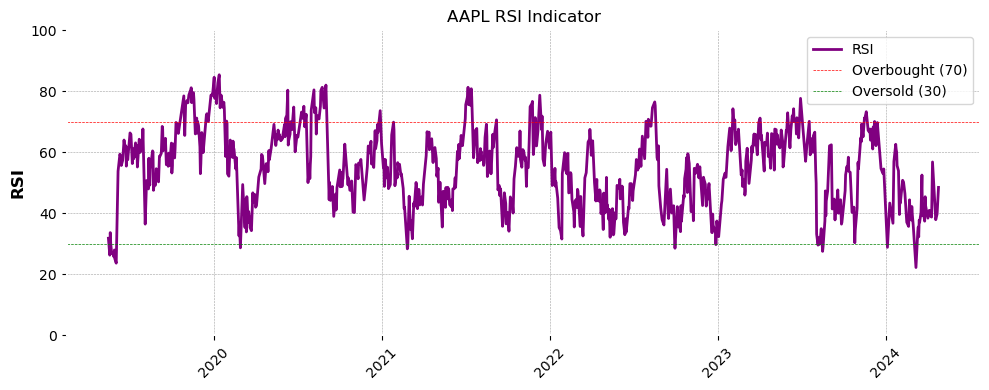

In [30]:
plt.figure(figsize=(10, 4))
plt.title('AAPL RSI Indicator')
plt.plot(aapl_data.index, aapl_data['rsi'], label='RSI', color='purple')  # Ensure 'rsi' is the column name
plt.axhline(70, color='red', linestyle='--', linewidth=0.5, label='Overbought (70)')
plt.axhline(30, color='green', linestyle='--', linewidth=0.5, label='Oversold (30)')
plt.ylim([0, 100])  # RSI ranges from 0 to 100
plt.ylabel('RSI')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.tight_layout()
plt.show()


## Bollinger Bands

In [26]:
#Fixes the None problem
def safe_bbands1(x):
    result = pandas_ta.bbands(close=np.log1p(x), length=14)
    if result is not None:
        return result.iloc[:, 0] 
    else:
        return pd.Series([None] * len(x), index=x.index)  


df['bb_low'] = df.groupby(level=1)['adj close'].transform(safe_bbands1)

def safe_bbands2(x):
    result = pandas_ta.bbands(close=np.log1p(x), length=14)
    if result is not None:
        return result.iloc[:, 1] 
    else:
        return pd.Series([None] * len(x), index=x.index)  

# Apply the safe_bbands function
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(safe_bbands2)

def safe_bbands3(x):
    result = pandas_ta.bbands(close=np.log1p(x), length=14)
    if result is not None:
        return result.iloc[:, 2]  
    else:
        return pd.Series([None] * len(x), index=x.index)  


df['bb_high'] = df.groupby(level=1)['adj close'].transform(safe_bbands3)

#Joins with df
def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

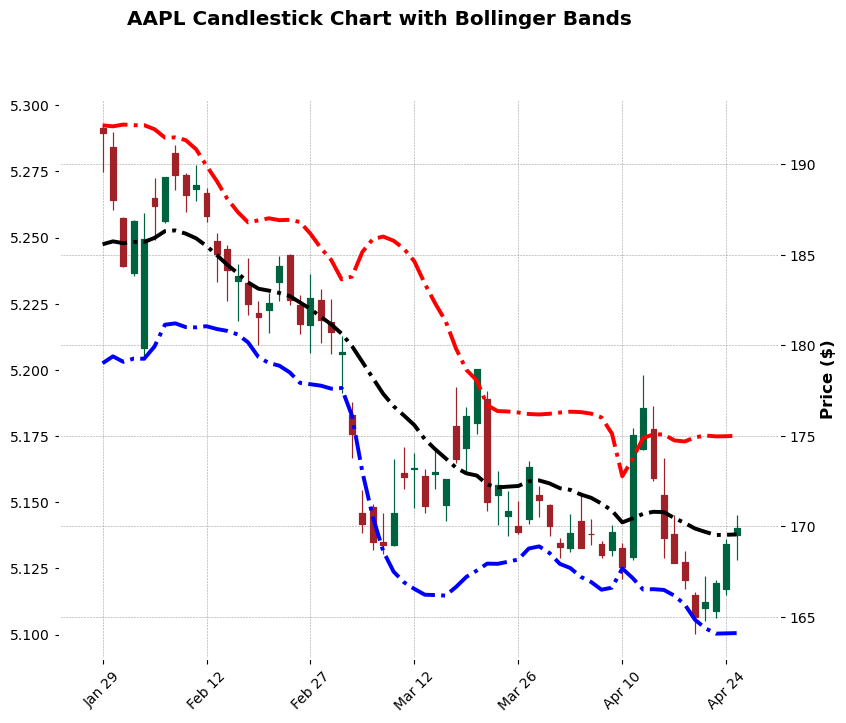

In [27]:
aapl_start_date = pd.to_datetime(end_date)-pd.DateOffset(100)


apple_data = df.loc[(slice(aapl_start_date, end_date), 'AAPL'), :]

# Normalize the DataFrame for manipulation
apple_data = apple_data.reset_index()
apple_data['date'] = pd.to_datetime(apple_data['date'])
apple_data.set_index('date', inplace=True)  # Set 'date' as the index

add_plots = [
    mpf.make_addplot(apple_data['bb_low'], color='blue', linestyle='dashdot'),
    mpf.make_addplot(apple_data['bb_mid'], color='black', linestyle='dashdot'),
    mpf.make_addplot(apple_data['bb_high'], color='red', linestyle='dashdot')
]

# Create the candlestick chart with Bollinger Bands using apple_data
mpf.plot(apple_data, type='candle', style='charles', title='AAPL Candlestick Chart with Bollinger Bands', ylabel='Price ($)', addplot=add_plots, figsize=(10, 8))

## Moving Average Convergence/Divergence

In [31]:
def compute_macd(close):
    macd_result = pandas_ta.macd(close=close, fast=12, slow=26, signal=9)  
    if macd_result is not None and not macd_result.empty:
        macd = macd_result['MACD_12_26_9']
        return macd.sub(macd.mean()).div(macd.std())
    else:
        return pd.Series([None] * len(close), index=close.index)  

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)


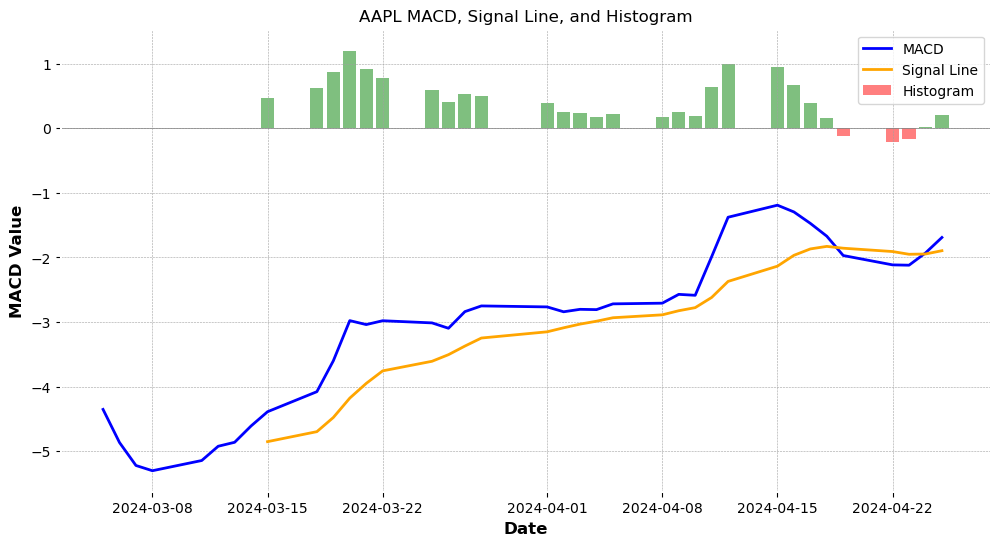

In [32]:
# Convert the Series to DataFrame if necessary, or ensure your data is in DataFrame format
if isinstance(apple_data['adj close'], pd.Series):
    close_prices = apple_data['adj close'].to_frame(name='close')

# Calculate MACD using pandas_ta
macd = pandas_ta.macd(close_prices['close'], fast=12, slow=26, signal=9)

# Add MACD calculations to the original data frame for plotting
apple_data['MACD'] = macd['MACD_12_26_9']
apple_data['Signal'] = macd['MACDs_12_26_9']
apple_data['Histogram'] = macd['MACDh_12_26_9']


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(apple_data.index, apple_data['MACD'], label='MACD', color='blue')
ax.plot(apple_data.index, apple_data['Signal'], label='Signal Line', color='orange')
ax.bar(apple_data.index, apple_data['Histogram'], label='Histogram', color=apple_data['Histogram'].apply(lambda x: 'green' if x > 0 else 'red'), alpha=0.5)

ax.axhline(0, color='gray', linewidth=0.5)  # Adds a baseline at 0

ax.set_title('AAPL MACD, Signal Line, and Histogram')
ax.set_xlabel('Date')
ax.set_ylabel('MACD Value')
ax.legend()
plt.show()

## Dolar Volume

In [33]:
df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

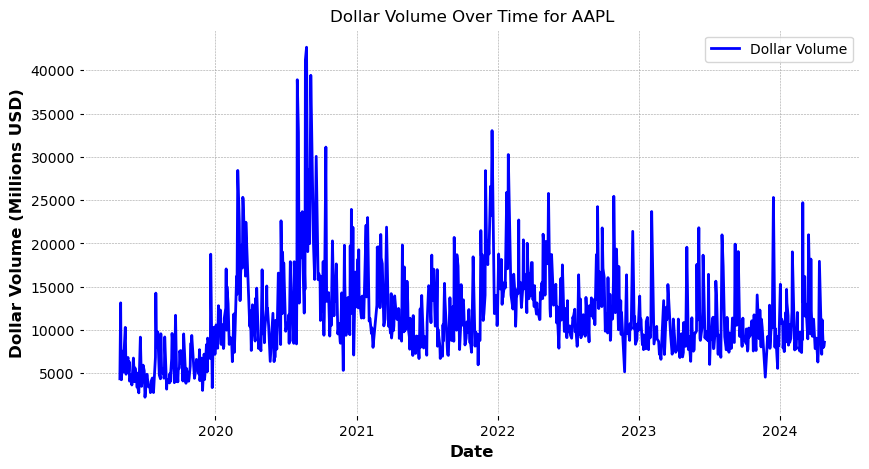

In [34]:
# Reset the index
df_reset = df.reset_index()

# Convert the 'date' column to datetime
df_reset['date'] = pd.to_datetime(df_reset['date'])

# Unstack the data
df_unstacked = df_reset.set_index(['date', 'ticker']).unstack()

# Now plot the data for 'AAPL'
plt.figure(figsize=(10, 5))
plt.plot(df_unstacked.index, df_unstacked[('dollar_volume', 'AAPL')], label='Dollar Volume', color='blue')
plt.title('Dollar Volume Over Time for AAPL')
plt.xlabel('Date')
plt.ylabel('Dollar Volume (Millions USD)')
plt.legend()
plt.grid(True)
plt.show()


# 3. Aggregate to monthly level and filter top 150 most liquid stocks for each month.

In [48]:
last_cols = [c for c in df.columns.unique() if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data.drop('level_0', axis=1, inplace=True)

data

dollar_volume     index   adj close  garman_klass_vol  \
date       ticker                                                          
2019-06-30 A          140.016428   21171.0   72.076370          0.000132   
           AAL        193.483627   21172.0   32.271446          0.000154   
           AAPL      4785.448080   21173.0   47.817772         -0.000482   
           ABBV       729.657843   21174.0   57.953785         -0.014439   
           ABT        435.004070   21175.0   77.251862         -0.002479   
...                          ...       ...         ...               ...   
2024-04-30 XYL        137.212962  624411.0  130.610001          0.000264   
           YUM        263.628668  624412.0  141.559998          0.000076   
           ZBH        137.037646  624413.0  119.750000          0.000206   
           ZBRA        93.501512  624414.0  292.529999          0.001355   
           ZTS        652.073789  624415.0  153.360001          0.000178   

                         rsi    bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                               
2019-06-30 A       66.786517  4.214692  4.255209  4.295726 -1.604048 -0.033887  
           AAL     57.471534  3.442010  3.487771  3.533532  0.471957  0.218825  
           AAPL    57.540681  3.858729  3.882731  3.906733 -1.838409 -0.114431  
           ABBV    41.861278  3.995424  4.115493  4.235562 -0.068023 -1.105925  
           ABT     66.681797  4.322227  4.351087  4.379947 -1.474838  0.865872  
...                      ...       ...       ...       ...       ...       ...  
2024-04-30 XYL     61.482745  4.843367  4.863772  4.884178 -0.152456  0.249134  
           YUM     65.668163  4.914062  4.937850  4.961639 -0.409506  0.421096  
           ZBH     35.636078  4.769259  4.821754  4.874250 -0.825956   -0.7325  
           ZBRA    56.172272  5.574158  5.654944  5.735729 -0.454850 -0.276747  
           ZTS     39.809619  4.957942  5.043798  5.129654  0.759311 -2.317643  

[29284 rows x 10 columns]

### Pegar as 150 mais liquidas

In [49]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

index   adj close  garman_klass_vol        rsi  \
date       ticker                                                      
2020-05-31 AAL     135153.0   10.500000          0.001347  49.229615   
           AAPL    135154.0   77.731537         -0.000162  64.328349   
           ABBV    135155.0   78.249947         -0.008152  64.711036   
           ABT     135156.0   88.612961          0.000488  59.326105   
           ACN     135158.0  190.511398         -0.001041  66.493834   
...                     ...         ...               ...        ...   
2024-04-30 VZ      624391.0   39.220001          0.000237  42.896054   
           WFC     624399.0   59.930000          0.000205  63.324078   
           WMT     624402.0   60.209999          0.000065  54.164438   
           XOM     624410.0  121.330002          0.000189  69.809165   
           ZTS     624415.0  153.360001          0.000178  39.809619   

                     bb_low    bb_mid   bb_high       atr      macd  
date       ticker                                                    
2020-05-31 AAL     2.256221  2.399307  2.542394  0.474898 -0.072758  
           AAPL    4.330789  4.355769  4.380749 -1.030772  0.646475  
           ABBV    4.322454  4.351637  4.380820  0.417923  0.792667  
           ABT     4.414357  4.459277  4.504197  1.373585  0.311166  
           ACN     5.131539  5.203886  5.276234 -0.146548  1.021466  
...                     ...       ...       ...       ...       ...  
2024-04-30 VZ      3.682108  3.712749  3.743390  0.017784 -0.388675  
           WFC     4.025860  4.083979  4.142097  0.098512  1.020056  
           WMT     4.095911  4.108439  4.120967  0.275276 -0.226605  
           XOM     4.780308  4.798965  4.817622  0.076300  1.270053  
           ZTS     4.957942  5.043798  5.129654  0.759311 -2.317643  

[7152 rows x 9 columns]

# 4. Compute Monthly Returns for Various Time Periods as Features.

To grasp the dynamics of time series, such as momentum patterns, we calculate historical returns using the method .pct_change(lag), which measures returns over different monthly periods specified by lags.

In [56]:
def calculate_returns(df):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

index   adj close  garman_klass_vol        rsi  \
date       ticker                                                      
2021-05-31 AAL     260009.0   24.240000          0.000383  63.403219   
           AAPL    260010.0  122.682190         -0.000159  42.829579   
           ABBV    260011.0  100.422882         -0.005546  47.956852   
           ABT     260013.0  110.532494         -0.000972  43.747152   
           ACN     260015.0  270.390778         -0.000698  46.038815   
...                     ...         ...               ...        ...   
2024-04-30 VRTX    624388.0  397.700012          0.000319  41.976274   
           VZ      624391.0   39.220001          0.000237  42.896054   
           WFC     624399.0   59.930000          0.000205  63.324078   
           WMT     624402.0   60.209999          0.000065  54.164438   
           XOM     624410.0  121.330002          0.000189  69.809165   

                     bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                     
2021-05-31 AAL     3.081143  3.170377  3.259611  0.229945  0.900131   
           AAPL    4.806347  4.826636  4.846924 -0.517776 -0.658551   
           ABBV    4.614712  4.638990  4.663268 -0.679731  0.099887   
           ABT     4.705141  4.718659  4.732177 -0.475117 -0.741437   
           ACN     5.591325  5.610035  5.628745 -0.661663 -0.309575   
...                     ...       ...       ...       ...       ...   
2024-04-30 VRTX    5.970426  5.990119  6.009811  0.402489 -1.209818   
           VZ      3.682108  3.712749  3.743390  0.017784 -0.388675   
           WFC     4.025860  4.083979  4.142097  0.098512  1.020056   
           WMT     4.095911  4.108439  4.120967  0.275276 -0.226605   
           XOM     4.780308  4.798965  4.817622  0.076300  1.270053   

                   return_1m  return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                          
2021-05-31 AAL      0.116022   0.007088   0.049990   0.094120   0.071224   
           AAPL    -0.050497   0.010877   0.009696   0.008172  -0.003330   
           ABBV     0.015247   0.028949   0.020718   0.017301   0.022976   
           ABT     -0.028564  -0.011590  -0.007576   0.013878   0.008317   
           ACN     -0.026934   0.012203   0.040988   0.022101   0.019356   
...                      ...        ...        ...        ...        ...   
2024-04-30 VRTX    -0.048587  -0.027766  -0.028233   0.015748   0.013547   
           VZ      -0.050164  -0.002062  -0.020036   0.024106   0.021445   
           WFC      0.033989   0.038302   0.063452   0.073570   0.032142   
           WMT      0.000665   0.015282   0.031276   0.018043   0.014866   
           XOM      0.043789   0.077418   0.060027   0.026143   0.016802   

                   return_12m  
date       ticker              
2021-05-31 AAL       0.068929  
           AAPL      0.038121  
           ABBV      0.021008  
           ABT       0.018590  
           ACN       0.029610  
...                       ...  
2024-04-30 VRTX      0.012967  
           VZ        0.006827  
           WFC       0.037522  
           WMT       0.016283  
           XOM       0.005022  

[5157 rows x 15 columns]

# 5. Finding correlation between the days of the week and how the market acts

In [55]:
# Extract data for a specific ticker, AAPL in this case
g = df.xs('AAPL', level=1)

g.index = pd.to_datetime(g.index.get_level_values(0))  # Adjust the level if necessary

# Calculate daily returns as percentage changes in the closing price
g['daily_returns'] = g['adj close'].pct_change()

# Determine the day of the week for each date (Monday=0, Sunday=6)
g['day_of_week'] = g.index.dayofweek

# Calculate the standard deviation of returns for each day of the week
weekly_volatility = g.groupby('day_of_week')['daily_returns'].std()

# Map day indices to day names
days = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
weekly_volatility.index = weekly_volatility.index.map(days)

# Display the volatility
print(weekly_volatility)

# Identify the day with the highest volatility
most_volatile_day = weekly_volatility.idxmax()
print(f"The most volatile day of the week for AAPL is {most_volatile_day} with a standard deviation of {weekly_volatility.max():.4f}.")


day_of_week
Monday       0.022315
Tuesday      0.018782
Wednesday    0.017411
Thursday     0.020627
Friday       0.021169
Name: daily_returns, dtype: float64
The most volatile day of the week for AAPL is Monday with a standard deviation of 0.0223.


In [58]:
g['daily_returns'] = g['adj close'].pct_change()
# Determine the day of the week (Monday=0, ..., Sunday=6)
g['day_of_week'] = g.index.dayofweek
# Calculate the mean of daily returns grouped by the day of the week
average_growth_by_day = g.groupby('day_of_week')['daily_returns'].mean()

# Map day indices to day names for better readability
days = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
average_growth_by_day.index = average_growth_by_day.index.map(days)

# Display the average growth by day of the week
print(average_growth_by_day)

# Identify the day with the highest average growth
day_with_most_growth = average_growth_by_day.idxmax()
print(f"The day of the week with the most growth for the S&P 500 is {day_with_most_growth} with an average growth of {average_growth_by_day.max() * 100:.2f}%.")


day_of_week
Monday       0.002529
Tuesday      0.001463
Wednesday    0.001513
Thursday     0.000029
Friday       0.000500
Name: daily_returns, dtype: float64
The day of the week with the most growth for the S&P 500 is Monday with an average growth of 0.25%.
